# LSTM-250 For Phoneme Recognition on TIMIT

**Architecture: mfcc-LSTM:250-LSTM:250-LSTM:250-FC:39**  
So, basically a 3 layered LSTM with 250 hidden units/state-vars.

Here, 
- LSTM: LSTM layer with given number of hidden units (state)
- FC: Fully connected layer for output mapping (no activation in the model)

**Naming Conventions**
- Small letter variables are local to a section
- Capitalized variables are used across sections
- Functions are always assumed to be used across sections

# Environment Setup

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.auto import tqdm


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.1  Device: cuda


# Loading Dataset

The DARPA TIMIT dataset can be downloaded from 
[here](https://www.kaggle.com/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech).
After downloading it, simply unzip it into `./dataset/TIMIT`.

In [2]:
Timit_path = "./dataset/TIMIT/"
Data_path = "./dataset/TIMIT/data/"
df_train = pd.read_csv(os.path.join(Timit_path, 'train_data.csv'))
df_test = pd.read_csv(os.path.join(Timit_path, 'test_data.csv'))
DF_dataset = pd.concat([df_train, df_test])
DF_dataset = DF_dataset[DF_dataset['is_converted_audio'] == False]
DF_dataset

,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
1,2.0,TRAIN,DR4,MMDM0,SI1311.PHN,TRAIN/DR4/MMDM0/SI1311.PHN,TRAIN\\DR4\\MMDM0\\SI1311.PHN,False,False,False,True,False
2,3.0,TRAIN,DR4,MMDM0,SI1311.WRD,TRAIN/DR4/MMDM0/SI1311.WRD,TRAIN\\DR4\\MMDM0\\SI1311.WRD,False,False,True,False,False
3,4.0,TRAIN,DR4,MMDM0,SX321.PHN,TRAIN/DR4/MMDM0/SX321.PHN,TRAIN\\DR4\\MMDM0\\SX321.PHN,False,False,False,True,False
4,5.0,TRAIN,DR4,MMDM0,SX321.WRD,TRAIN/DR4/MMDM0/SX321.WRD,TRAIN\\DR4\\MMDM0\\SX321.WRD,False,False,True,False,False
5,6.0,TRAIN,DR4,MMDM0,SI681.TXT,TRAIN/DR4/MMDM0/SI681.TXT,TRAIN\\DR4\\MMDM0\\SI681.TXT,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
8394,8395.0,TEST,DR8,MPAM0,SX19.WAV,TEST/DR8/MPAM0/SX19.WAV,TEST\\DR8\\MPAM0\\SX19.WAV,False,True,False,False,False
8395,8396.0,TEST,DR8,MPAM0,SX109.TXT,TEST/DR8/MPAM0/SX109.TXT,TEST\\DR8\\MPAM0\\SX109.TXT,False,False,False,False,True
8397,8398.0,TEST,DR8,MPAM0,SX289.WRD,TEST/DR8/MPAM0/SX289.WRD,TEST\\DR8\\MPAM0\\SX289.WRD,False,False,True,False,False
8398,8399.0,TEST,DR8,MPAM0,SX109.WAV,TEST/DR8/MPAM0/SX109.WAV,TEST\\DR8\\MPAM0\\SX109.WAV,False,True,False,False,False


# Split Dataset

## Merge Entries
One entry in the dataframe represents one file. Audio, word, and phonetics are stored separately in different files. Then, we would need to combine them.

In [3]:
merged_ds = {}

for idx, row in tqdm(DF_dataset.iterrows(), total=len(DF_dataset)):
    path = row['path_from_data_dir']
    entry_id = path.split('.')[0]

    if entry_id not in merged_ds:
        merged_ds[entry_id] = {}

    if row['is_audio'] is True:
        merged_ds[entry_id]['audio_file'] = os.path.join(Data_path, path)
    elif row['is_word_file'] is True:
        merged_ds[entry_id]['word_file'] = os.path.join(Data_path, path)
    elif row['is_phonetic_file'] is True:
        merged_ds[entry_id]['phonetic_file'] = os.path.join(Data_path, path)
    elif row['is_sentence_file'] is True:
        merged_ds[entry_id]['sentence_file'] = os.path.join(Data_path, path)
    
    if row['test_or_train'].strip()=='TEST':
        merged_ds[entry_id]['is_test'] = True
    else:
        merged_ds[entry_id]['is_test'] = False

  0%|          | 0/25200 [00:00<?, ?it/s]

In [4]:
# Check the data fields
records = list(merged_ds.keys())
print('Record Keys:', records[:3])

fields = list(merged_ds[records[0]].keys())
print('Fields:', fields)

print('\nField values')
for k,v in merged_ds[records[0]].items():
    print(f'{k:>15}',':',v)

Record Keys: ['TRAIN/DR4/MMDM0/SI1311', 'TRAIN/DR4/MMDM0/SX321', 'TRAIN/DR4/MMDM0/SI681']
Fields: ['phonetic_file', 'is_test', 'word_file', 'sentence_file', 'audio_file']

Field values
  phonetic_file : ./dataset/TIMIT/data/TRAIN/DR4/MMDM0/SI1311.PHN
        is_test : False
      word_file : ./dataset/TIMIT/data/TRAIN/DR4/MMDM0/SI1311.WRD
  sentence_file : ./dataset/TIMIT/data/TRAIN/DR4/MMDM0/SI1311.TXT
     audio_file : ./dataset/TIMIT/data/TRAIN/DR4/MMDM0/SI1311.WAV


## Split into Train and Test Subsets

In [5]:
# Separate the keys
train_keys = []
test_keys = []
for key in merged_ds:
    if merged_ds[key]['is_test']: test_keys.append(key)
    else: train_keys.append(key)

In [6]:
# Separate the dataset based on the separated keys
Train_dataset = { key:merged_ds[key] for key in train_keys }
Test_dataset  = { key:merged_ds[key] for key in test_keys }
train_len = len(Train_dataset)
test_len = len(Test_dataset)
train_ratio = train_len*100/(train_len+test_len)
test_ratio = test_len*100/(train_len+test_len)
print('Train_dataset#:', train_len, '\nTest_dataset#:', test_len)
print('Ratio: Train-Test', f'{train_ratio:.1f}%-{test_ratio:.1f}%' )

Train_dataset#: 4620 
Test_dataset#: 1680
Ratio: Train-Test 73.3%-26.7%


In [7]:
def get_durations(dict_data):
    total_durations = 0
    for entry in tqdm(dict_data.values()):
        audio_data, rate = librosa.load(entry['audio_file'], sr=None)
        duration = len(audio_data) / rate
        total_durations += duration
    return int(total_durations)


print(f"Duration of Train: {get_durations(Train_dataset) // 60} mins")
print(f"Duration of Test : {get_durations(Test_dataset) // 60} mins")

  0%|          | 0/4620 [00:00<?, ?it/s]

Duration of Train: 236 mins


  0%|          | 0/1680 [00:00<?, ?it/s]

Duration of Test : 86 mins


# Explore Dataset to Understand

Note: 
- The dataset contains a list of file paths.
- The file types are specified as keys.
    - `audio_file`: path to audio file
    - `is_test`: True/False indicating if it belongs to training/testing dataset
    - `sentence_file`: path to the text file containing the sentence spoken in the audio file
    - `word_file`: a list of (start index, end index, word) perline in the audio
    - `phonetic_file`: a list of (start index, end index, phoneme) perline in the audio

In [8]:
# Extract an item from the train_set
train_keys = list(Train_dataset.keys())
item_info = Train_dataset[train_keys[20]]
item_info

{'audio_file': './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.WAV',
 'is_test': False,
 'sentence_file': './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.TXT',
 'word_file': './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.WRD',
 'phonetic_file': './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.PHN'}

In [9]:
# Play an audio file
with open(item_info['sentence_file'], 'r') as infile: print(infile.read())
wave, rate = librosa.load(item_info['audio_file'], sr=None)
ipd.Audio(wave, rate=rate)

0 76392 Within a system, however, the autonomy of each member library is preserved.



In [10]:
# List the phoneme slices
phoneme_slice = {}
with open(item_info['phonetic_file'], 'r') as infile:
    for line in infile:
        start, end, phone = line.split()
        phoneme_slice[phone] = (int(start), int(end))
print('Phoneme count:', len(phoneme_slice))
phoneme_slice

Phoneme count: 35


{'h#': (74187, 76320),
 'w': (2280, 2573),
 'ix': (61720, 63080),
 'th': (3160, 4360),
 'ih': (9320, 10680),
 'n': (5305, 6040),
 'ax': (13080, 13827),
 's': (10680, 12200),
 'tcl': (43000, 43816),
 't': (31800, 32877),
 'm': (47994, 48809),
 'hv': (14920, 16120),
 'aw': (16120, 19383),
 'eh': (46490, 47994),
 'v': (71722, 72685),
 'axr': (65960, 66840),
 'epi': (44825, 45905),
 'dh': (28280, 28783),
 'uh': (28783, 30760),
 'aa': (32877, 35120),
 'nx': (35120, 35520),
 'ah': (35520, 36280),
 'iy': (58647, 59774),
 'ch': (43816, 44825),
 'bcl': (54280, 55240),
 'b': (55240, 55640),
 'l': (50520, 51800),
 'ay': (51800, 54280),
 'r': (55640, 56516),
 'er': (68600, 71722),
 'q': (59774, 61720),
 'z': (66840, 68600),
 'pcl': (64440, 65320),
 'p': (65320, 65960),
 'dcl': (72685, 74187)}

In [11]:
# Extract a phoneme in play it
phone = 'er'
start, end = phoneme_slice[phone]
phone_wave = wave[start:end]
ipd.Audio(phone_wave, rate=rate)

# Build Dataset Classes for Dataloader: Phoneme

Notes:
- This is a cached data loader
- Given an index, returns a tuple as (wave, sample_rate, label)
    - wave: librosa waveform
    - label: phoneme
- Can request a list of labels

## Sentence record to phoneme record converter

In [12]:
# Function to convert a sentence record into a list of phoneme record.
# Returns a list of tuples: (phoneme, path-to-audio, start-index, end-index)
def buildPhoneRecords(sentence_record):
    audio_path = sentence_record['audio_file']
    phone_path  = sentence_record['phonetic_file']
    phone_records = []
    with open(phone_path, 'r') as infile:
        for line in infile:
            start, end, phone = line.split()
            phone_records.append((phone, audio_path, int(start), int(end)))
    return phone_records


# Extract an item from the train_dataset to test above function
train_keys = list(Train_dataset.keys())
sentence_record = Train_dataset[train_keys[20]]
print('sentence_record:', sentence_record)

phone_records = buildPhoneRecords(sentence_record)
print('Phoneme records:', len(phone_records))
phone_records[:10]

sentence_record: {'audio_file': './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.WAV', 'is_test': False, 'sentence_file': './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.TXT', 'word_file': './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.WRD', 'phonetic_file': './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.PHN'}
Phoneme records: 59


[('h#', './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.WAV', 0, 2280),
 ('w', './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.WAV', 2280, 2573),
 ('ix', './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.WAV', 2573, 3160),
 ('th', './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.WAV', 3160, 4360),
 ('ih', './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.WAV', 4360, 5305),
 ('n', './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.WAV', 5305, 6040),
 ('ax', './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.WAV', 6040, 7320),
 ('s', './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.WAV', 7320, 9320),
 ('ih', './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.WAV', 9320, 10680),
 ('s', './dataset/TIMIT/data/TRAIN/DR4/MCDR0/SI524.WAV', 10680, 12200)]

In [13]:
# Play a phoneme record
phone, audio_path, start, end = phone_records[46]
wave, rate = librosa.load(audio_path, sr=None)
wave = wave[start:end]
print('phone:', phone)
ipd.Audio(wave, rate=rate)

phone: er


## Dataset Class

This dataset class takes in the TIMIT dataset dictionary built earlier then breaks it down to build a phoneme-level dataset.   
It returns an example as tuple: **(phoneme, wave, sample_rate)**

Notes:
- TimitPhoneDataset[0]: (phoneme, wave, sample_rate)
- phone_records[0]: (phoneme, path-to-audio, start-index, end-index)

In [14]:
from torch.utils.data import Dataset


class TimitPhoneDataset(Dataset):
    def __init__(self, dataset_dict):
        self.base_dataset = dataset_dict
        self.phone_records = []
        count_missing = 0        # some records have missing phonetic files, let's count it
        for key, sent_rec in dataset_dict.items():
            # Skip missing phonetic-file records
            if 'phonetic_file' not in sent_rec:
                count_missing += 1
                continue
            # break the sentence reconds into phoneme records
            phone_recs = buildPhoneRecords(sent_rec)
            self.phone_records.extend(phone_recs)
        if(count_missing>0): print(f"WARN: Missing phonetic files for {count_missing} records")
        self.audio_cache = {}   # for caching audio files
           
    def __len__(self):
        return len(self.phone_records)
 
    # Returns: (phoneme, wave, sample_rate)
    def __getitem__(self, index):
        # self.phone_records[i]: (phoneme, path-to-audio, start-index, end-index)
        phone, audio_path, start, end = self.phone_records[index]
        wave, rate = self.__getWaveSlice(audio_path, start, end)
        return phone, wave, rate
    
    
    # Returns the audio slice given filename, start, end
    # Return: (wave-slice, sample_rate)
    def __getWaveSlice(self, audio_path, start, end):
        # Check in audio cache. On miss, load into cache
        if audio_path in self.audio_cache:
            wave, rate = self.audio_cache[audio_path]
        else:
            wave, rate = librosa.load(audio_path, sr=None)
            self.audio_cache[audio_path] = (wave, rate)
        # Return the selected slice
        return wave[start:end], rate
    
    # Returns a set of all labels in this dataset
    def getLabels(self):
        labels = set()
        for rec in self.phone_records:
            labels.add(rec[0])
        return labels
    
    # Returns a dictionary of all labels:counts in this dataset
    def getLabelCounts(self):
        labels = {}
        for rec in self.phone_records:
            if rec[0] not in labels: labels[rec[0]] = 0
            labels[rec[0]] += 1
        return labels

    # This function can be used to trim down the dataset for faster experimentation
    # Removes all records except the ones with in listKeep
    def keepLabels(self, listKeep):
        setKeep = set(listKeep)
        keep_rec = []
        for prec in self.phone_records:
            # only keep the specified words
            if prec[0] in setKeep:
                keep_rec.append(prec)
        self.phone_records = keep_rec
    
    # This can be used to change the label.
    # dict_map: (current label, remapped label)
    def remapLabels(self, dict_map):        
        # self.phone_records[i]: (phoneme, path-to-audio, start-index, end-index)
        for index, _ in enumerate(self.phone_records):
            phone, audio_path, start, end = self.phone_records[index]
            mapped_phone = dict_map[phone]
            self.phone_records[index] = (mapped_phone, audio_path, start, end)
        
        
    
# Instantiate the datasets
print('Loading Train set ...')
Train_phone_set = TimitPhoneDataset(Train_dataset)
print('Done!')

print('\nLoading Test set ...')
Test_phone_set = TimitPhoneDataset(Test_dataset)
print('Done!')

Loading Train set ...
WARN: Missing phonetic files for 2940 records
Done!

Loading Test set ...
Done!


In [15]:
# Test if it works as expected
phone, wave, rate = Train_phone_set[351]
print(phone)
ipd.display(ipd.Audio(wave, rate=rate))

phone, wave, rate = Test_phone_set[400]
print(phone)
ipd.display(ipd.Audio(wave, rate=rate))

pau


sh


## Remap Phonemes 61 to 39 classes

As we can see the result below, there are 61 phones. However, we don't need to use all of them. "tcl", for example, is just a pause where there is a "t". So, let's keep it up and simplify them a bit.

**NOTE:** The 61 phones defined in TIMIT dataset are remapped to 39 English phones. For details checkout the papers 
[[1]](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=46546)
[[2]](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=6638947)


In [16]:
all_train_labels = Train_phone_set.getLabelCounts()
print('all_train_labels Len:', len(all_train_labels))
print(all_train_labels.keys())

all_train_labels Len: 61
dict_keys(['h#', 's', 'ao', 'l', 'r', 'iy', 'dcl', 'd', 'eh', 'pcl', 'p', 'ix', 'z', 'ih', 'sh', 'n', 'pau', 'v', 'aa', 'y', 'uw', 'w', 'ey', 'dx', 'b', 'ay', 'ng', 'kcl', 'k', 'epi', 'tcl', 'ch', 'dh', 'er', 'en', 'gcl', 'g', 'aw', 'hv', 'ae', 'ow', 'q', 't', 'ax', 'm', 'ah', 'f', 'ux', 'zh', 'el', 'bcl', 'nx', 'axr', 'ax-h', 'jh', 'oy', 'uh', 'hh', 'th', 'eng', 'em'])


In [17]:
# TimitBet 61 phoneme mapping to 39 phonemes
# by Lee, K.-F., & Hon, H.-W. (1989). Speaker-independent phone recognition using hidden Markov models. IEEE Transactions on Acoustics, Speech, and Signal Processing, 37(11), 1641–1648. doi:10.1109/29.46546 
phon61_map39 = {
    'iy':'iy',  'ih':'ih',   'eh':'eh',  'ae':'ae',    'ix':'ih',   'ax':'ah',   'ah':'ah',   'uw':'uw',
    'ux':'uw',  'uh':'uh',   'ao':'aa',  'aa':'aa',    'ey':'ey',   'ay':'ay',   'oy':'oy',   'aw':'aw',
    'ow':'ow',  'l':'l',     'el':'l',   'r':'r',      'y':'y',     'w':'w',     'er':'er',   'axr':'er',
    'm':'m',    'em':'m',    'n':'n',    'nx':'n',     'en':'n',    'ng':'ng',   'eng':'ng',  'ch':'ch',
    'jh':'jh',  'dh':'dh',   'b':'b',    'd':'d',      'dx':'dx',   'g':'g',     'p':'p',     't':'t',
    'k':'k',    'z':'z',     'zh':'sh',  'v':'v',      'f':'f',     'th':'th',   's':'s',     'sh':'sh',
    'hh':'hh',  'hv':'hh',   'pcl':'h#', 'tcl':'h#',   'kcl':'h#',  'qcl':'h#',  'bcl':'h#',  'dcl':'h#',
    'gcl':'h#', 'h#':'h#',   '#h':'h#',  'pau':'h#',   'epi': 'h#', 'nx':'n',    'ax-h':'ah', 'q':'h#' 
}

Train_phone_set.remapLabels(phon61_map39)
Test_phone_set.remapLabels(phon61_map39)

In [18]:
all_train_labels = Train_phone_set.getLabelCounts()
all_test_labels = Train_phone_set.getLabelCounts()
print('all_train_labels Len:', len(all_train_labels))
print('all_test_labels Len :', len(all_test_labels))
print('Are labels the same :', all_train_labels == all_test_labels)
print(all_train_labels)

all_train_labels Len: 39
all_test_labels Len : 39
Are labels the same : True
{'h#': 14178, 's': 2773, 'aa': 2133, 'l': 2438, 'r': 2344, 'iy': 2524, 'd': 1261, 'eh': 1426, 'p': 916, 'ih': 4926, 'z': 1386, 'sh': 826, 'n': 3235, 'v': 747, 'y': 640, 'uw': 919, 'w': 1147, 'ey': 817, 'dx': 1016, 'b': 765, 'ay': 858, 'ng': 477, 'k': 1766, 'ch': 317, 'dh': 1053, 'er': 2094, 'g': 722, 'aw': 277, 'hh': 771, 'ae': 1422, 'ow': 778, 't': 1602, 'ah': 2339, 'm': 1471, 'f': 765, 'jh': 456, 'oy': 237, 'uh': 187, 'th': 269}


# Trim Down Dataset

If needed, trim down the dataset here for faster experimentation

Text(0.5, 1.0, 'Test Phoneme Distribution')

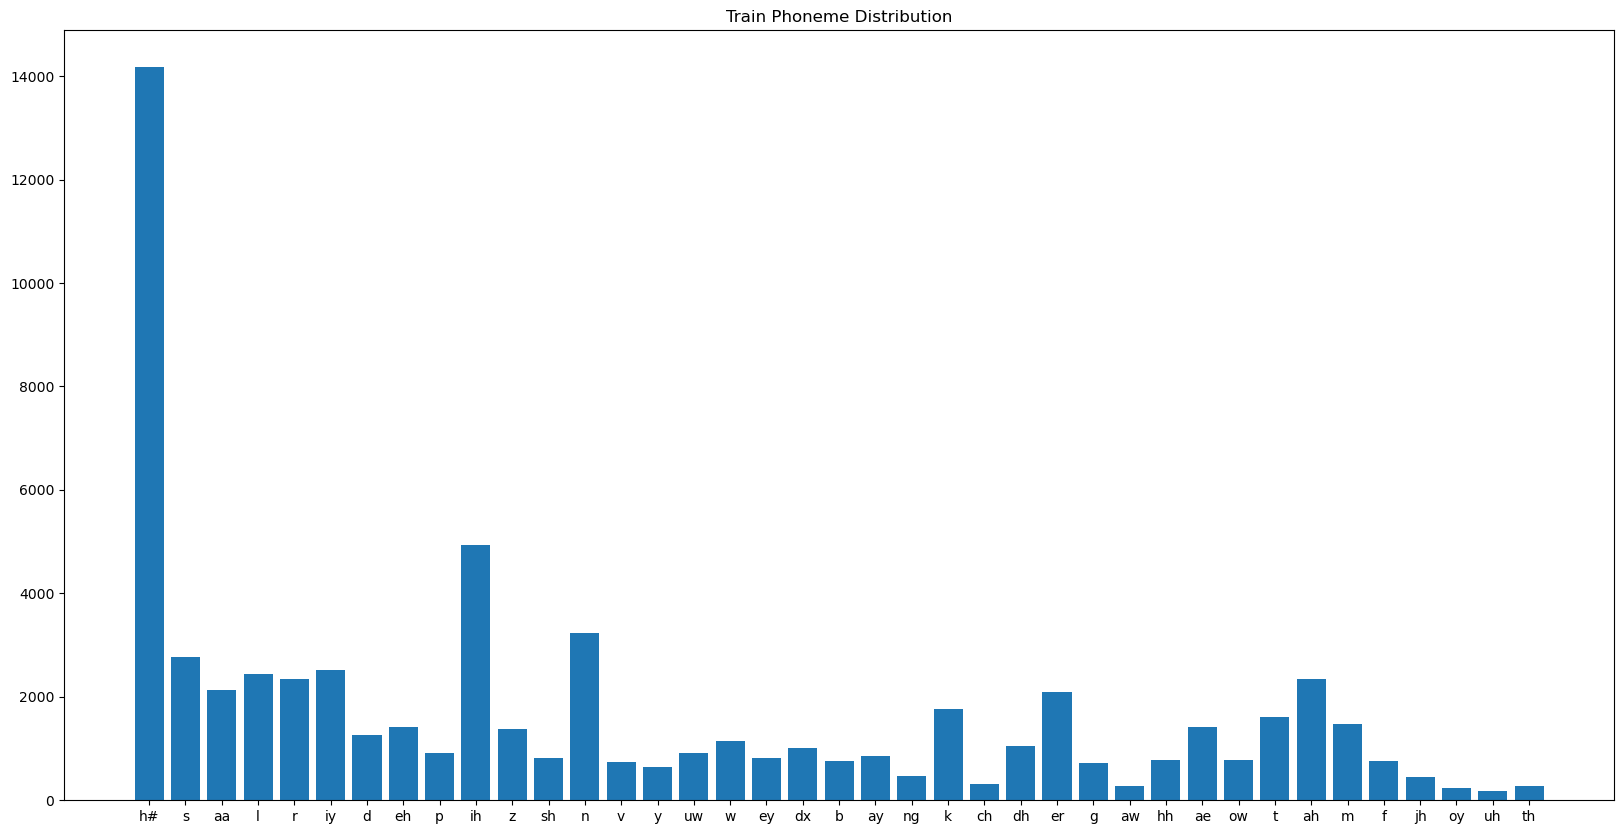

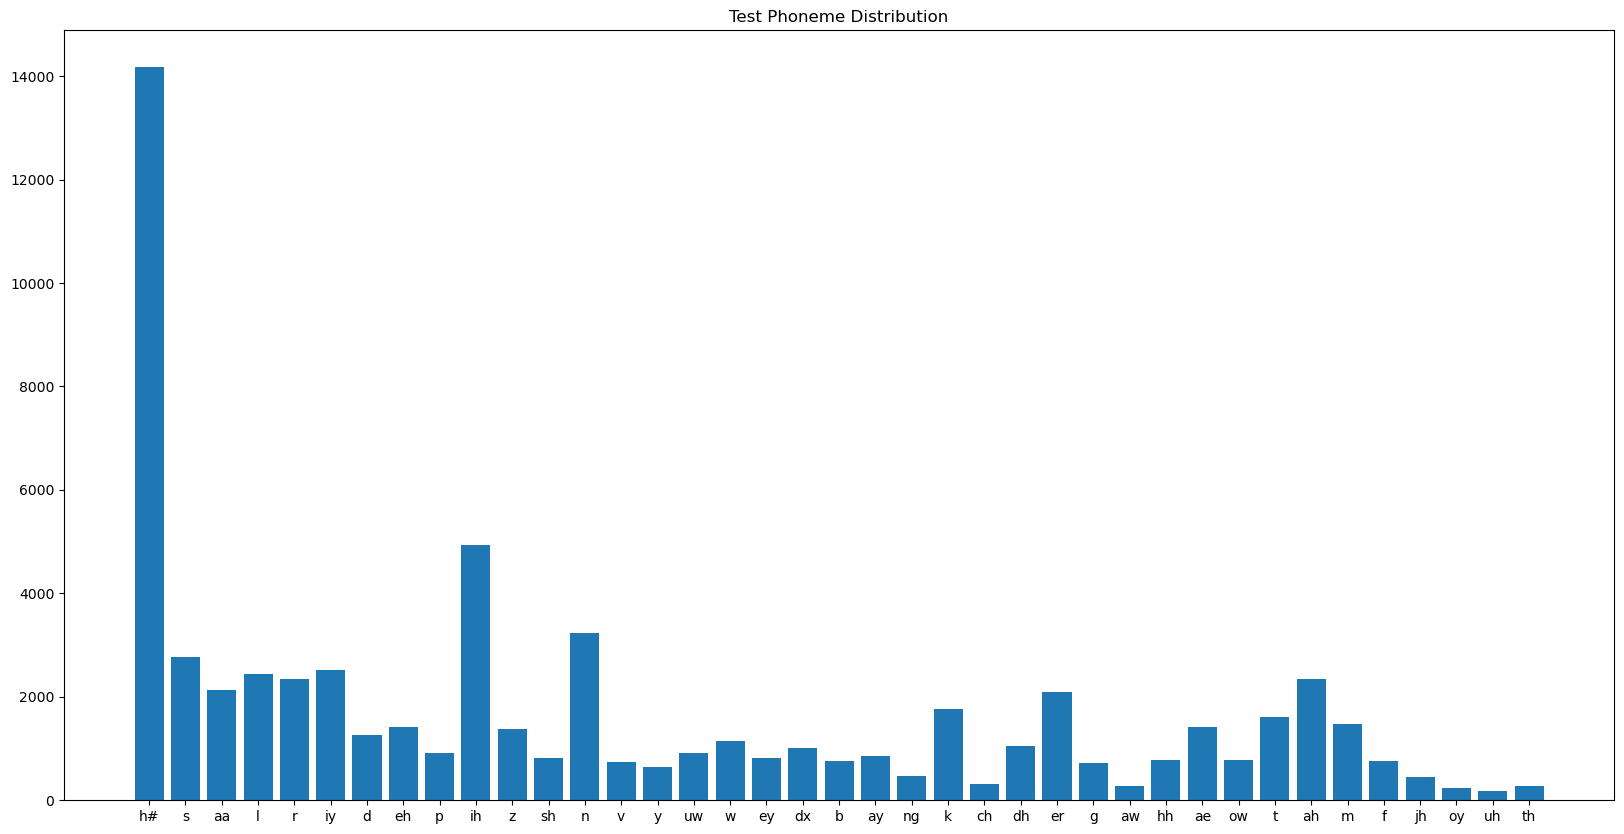

In [19]:
# Check the dataset statistics
plt.figure(figsize=(20,10))
plt.bar(all_train_labels.keys(), all_train_labels.values())
plt.title('Train Phoneme Distribution')

plt.figure(figsize=(20,10))
plt.bar(all_test_labels.keys(), all_test_labels.values())
plt.title('Test Phoneme Distribution')

In [20]:
# Delete exceptionally common keys
del_keys = ['h#', 'ih','er','n','ah']
for key in del_keys: 
    if key in all_train_labels: del(all_train_labels[key])
    
# keep n most common keys
keep_count = 5
sorted_labels = [(cnt, word) for word, cnt in all_train_labels.items()]
sorted_labels = sorted(sorted_labels, reverse=True)
#sorted_labels
keep_labels = sorted_labels[:keep_count]
print('\nkeep_labels:', keep_labels)


keep_labels: [(2773, 's'), (2524, 'iy'), (2438, 'l'), (2344, 'r'), (2133, 'aa')]


## Deactivated for training on whole dataset
```python
# Trim Down Dataset: Deactivate this cell to avoid trimming
keep_labels = [tup[1] for tup in keep_labels]
print('\nBefore: Train#', len(Train_phone_set), '  Test#', len(Test_phone_set))
Train_phone_set.keepLabels(keep_labels)
Test_phone_set.keepLabels(keep_labels)
```

In [21]:
print('After : Train#', len(Train_phone_set), '  Test#', len(Test_phone_set))

Labels = list(Train_phone_set.getLabels())    # save for later use
print('\nLabels:', len(Labels), '\n', Labels)

After : Train# 64278   Test# 64145

Labels: 39 
 ['p', 'uh', 'ch', 'h#', 'b', 'd', 'y', 'ae', 'dx', 'n', 'ah', 'r', 'eh', 'k', 'ng', 'aa', 'ow', 'uw', 'w', 'f', 'aw', 'l', 'g', 'iy', 'sh', 'ih', 'jh', 'ey', 'z', 'hh', 't', 'er', 'ay', 'oy', 'th', 's', 'dh', 'm', 'v']


# Define Features

```python
# Features: MFCC coefficients
Feature_length = 40
FFT_window = 32

Feature_note = f'Features are extracted using librosa.feature.mfcc(y=wave, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft). n_mfcc: {Feature_length}  n_fft: {FFT_window}'

# Takes a dataset item and returns the feature vector
# item: (phoneme, wave, sample_rate)
def extract_features(item):
    _, wave, sample_rate = item
    n_mfcc = Feature_length
    n_fft = FFT_window   # FFT window
    # Increase sample rate as the phonemes are pretty short recording (made the training worse)
    #scale_fact = 4
    #wave = librosa.resample(y=wave, orig_sr=sample_rate, target_sr=sample_rate*scale_fact)
    #sample_rate *= scale_fact
    return librosa.feature.mfcc(y=wave, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft)
```

In [22]:
# Features: MFCC coefficients
FFT_window = 32
Mel_count = 40
Interp_width = 3


# Takes a dataset item and returns the feature vector
# item: (phoneme, wave, sample_rate)
def extract_features_v1(item):
    _, wave, sample_rate = item
    # Compute Mel-scale filter bank coefficients
    n_fft = FFT_window  # Number of FFT points
    n_mels = Mel_count   # Number of Mel bins
    hop_length = 8  # Hop length for computing the STFT
    mel_spec = librosa.feature.melspectrogram(y=wave, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec)  # Convert to log-scale

    # Compute energy term (sum of squared magnitudes of the STFT)
    #stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    #energy = librosa.feature.rms(S=stft)

    # Extract the first 40 coefficients and the energy term
    mel_coefficients = log_mel_spec[:Mel_count]
    #energy = energy.squeeze()
    return mel_coefficients


# Takes a dataset item and returns the feature vector
# item: (phoneme, wave, sample_rate)
def extract_features(item):
    _, wave, sample_rate = item
    # Compute Mel-scale filter bank coefficients
    n_fft = FFT_window  # Number of FFT points
    n_mels = Mel_count   # Number of Mel bins
    hop_length = 16      # Hop length for computing the STFT
    mel_spec = librosa.feature.melspectrogram(y=wave, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec)  # Convert to log-scale
    # Compute first-order temporal derivatives
    delta_mel = librosa.feature.delta(log_mel_spec, width=Interp_width)
    # Compute second-order temporal derivatives
    delta2_mel = librosa.feature.delta(log_mel_spec, width=Interp_width, order=2)
    # build feature vector from above features coefficients
    #print('long_mel_spec:', log_mel_spec.shape)
    #print('delta:', delta_mel.shape)
    #print('delta2:', delta2_mel.shape)
    feat_vec = np.vstack([log_mel_spec, delta_mel, delta2_mel])
    #feat_vec_norm = normalizeAlongColumns(feat_vec)
    #print('feat_vec:', feat_vec.shape)
    return feat_vec


# Normalizes a numpy 2D array along columns
def normalizeAlongColumns(nparr, eps=0.001):
    assert len(nparr.shape) == 2, "Expected 2D Numpy array"
    mean = np.mean(nparr, axis=0)
    std  = np.std(nparr, axis=0)
    std  = np.where(std==0, eps, std)   # replace 0 with eps, to avoid division by zero
    normalized = (nparr - mean) / std
    return normalized

feat_vec: (120, 56)
h#


/home/makabir/miniconda3/envs/pytorch/lib/python3.11/site-packages/librosa/feature/spectral.py:2157: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


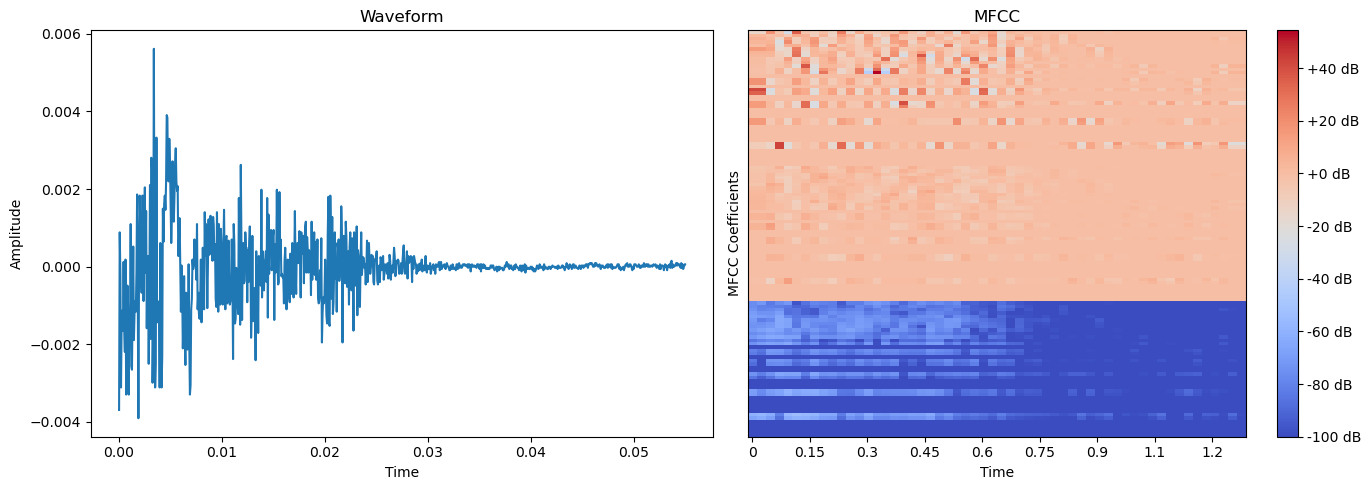

In [23]:
%matplotlib inline

# Extract features of a sample and plot them
# Generated by ChatGPT
def plot_audio_and_mfcc_gpt(audio, sample_rate, mfcc_features):
    plt.figure(figsize=(14, 5))
    
    # Plot the waveform
    plt.subplot(1, 2, 1)
    duration = len(audio) / sample_rate
    time = np.linspace(0, duration, len(audio))
    plt.plot(time, audio)
    plt.title('Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    
    # Plot the MFCC feature
    plt.subplot(1, 2, 2)
    librosa.display.specshow(mfcc_features, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')
    
    plt.tight_layout()
    plt.show()

    
# Extract mfcc coefficients
item = Train_phone_set[200]
feat_vec = extract_features(item)
print('feat_vec:', feat_vec.shape)


Feature_length = feat_vec.shape[0]    # no. of rows is the number of features here
#Feature_note = f'Features are extracted using librosa.feature.mfcc(y=wave, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft). n_mfcc: {Feature_length}  n_fft: {FFT_window}'
Feature_note = "Undefined"

phone, wave, rate = item
print(phone)
ipd.display(ipd.Audio(wave, rate=rate))
plot_audio_and_mfcc_gpt(wave, rate, feat_vec)

# Define Model

In [24]:
import torch.nn.utils.rnn as rnn_utils


# LSTM model definition
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.debug = False    # Set it to true to print debug info
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    # Expects a padded_sequence of batched input and the lengths of the sequences
    def forward(self, pad_seq, lengths):        
        if self.debug: print('DEBUG START: LSTM model ---')

        # Extract batch size for initialization of hidden state
        batch_size = len(pad_seq)
            
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        
        # Convert padded sequence to variable length packed sequence for LSTM
        packed_seq = rnn_utils.pack_padded_sequence(pad_seq, lengths, enforce_sorted=False, batch_first=True)
        
        # Forward propagate LSTM, returns a packed sequence
        out_packed, _ = self.lstm(packed_seq, (h0, c0))
        
        # Extract final hidden states of each sequence for the output layer
        out_pad, out_lens = rnn_utils.pad_packed_sequence(out_packed, batch_first=True)
        out_indx = out_lens - 1   # indices of the last valid hidden state in the padded sequence
        last_hidden = out_pad[range(batch_size), out_indx].contiguous()  # select the last valid state in each sequence, and make them contiguous for efficiency
                
        if self.debug:
            print('last_hidden size:', last_hidden.size())
            print('last_hidden:\n', last_hidden)
        
        # Decode the hidden state of the last time step only (for whole batch)
        out = self.fc(last_hidden)
        if self.debug: print('DEBUG END: LSTM model ---')
        return out

In [25]:
# Instantiate the LSTM
input_size  = Feature_length    # no. of mfcc coefficients
hidden_size = 250               # no. of hiddent units in LSTM
num_layers  = 3
num_classes = len(Labels)
model_lstm250  = LSTM(input_size, hidden_size, num_layers, num_classes)
model_lstm250.to(device)
print(model_lstm250)


# Save the model parameters
Hparam = {
    'input_size' : input_size,
    'hidden_size': hidden_size,
    'num_layers' : num_layers,
    'num_classes': num_classes, 
}

LSTM(
  (lstm): LSTM(120, 250, num_layers=3, batch_first=True)
  (fc): Linear(in_features=250, out_features=39, bias=True)
)


# Define Dataloaders

In [26]:
# Utilities to convert between label and index

Label2index = {label:index for index, label in enumerate(Labels)}

def label_to_index(phone):
    # Return the position of the word in labels
    return torch.tensor(Label2index[phone])

def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return Labels[index]


# Test the utilities
phone_start = Labels[2]
index = label_to_index(phone_start)
phone_recovered = index_to_label(index)

print(phone_start, "-->", index, "-->", phone_recovered)

ch --> tensor(2) --> ch


In [27]:
# Padding is needed to make the batch <tensor> from <list> of variable length sequences
# The padding values are not passed to the LSTM during trainig/testing
def pad_sequence_lstm(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = rnn_utils.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch

# Gets the list of audio and labels as batch then
# converts them into sequence of features for the model.
# Adds padding to build the batch tensor
def collate_fn_lstm(batch):
    # A data tuple has the form: (phoneme, wave, sample_rate)
    tensors, targets, lengths = [], [], []   # lengths is needed for pack_padded_sequence during training/testing

    # Gather in lists, and encode labels as indices
    for item in batch:
        label, waveform, rate = item
        features = extract_features(item)
        features = torch.from_numpy(features).t()    # Transpose needed to make it (points, no. of features)
        tensors += [features]
        targets += [label_to_index(label)]
        lengths.append(features.size()[0])

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence_lstm(tensors)
    targets = torch.stack(targets)
    lengths = torch.tensor(lengths)
    return tensors, targets, lengths



# Test padding function
batch = [   torch.tensor([2,3,4,5]), 
            torch.tensor([2,3]),
            torch.tensor([5,6,7])    ]
pad_seq = pad_sequence_lstm(batch)
print('pad_seq:\n', pad_seq)

# Test collate function
batch = [Test_phone_set[i*21] for i in range(5)]
col_tensor, col_targets, col_lengths = collate_fn_lstm(batch)
print('\ncollate_out:\n', col_tensor.size(), '\n', col_targets, '\n', col_lengths)

# Manual features to compare
print('')
phone, wave, rate = batch[1]
print('phone:', phone)
ipd.Audio(wave, rate=rate)
mfcc = librosa.feature.mfcc(y=wave, sr=rate, n_mfcc=Feature_length, n_fft=FFT_window)
print('mfcc shape:', mfcc.shape)

pad_seq:
 tensor([[2, 3, 4, 5],
        [2, 3, 0, 0],
        [5, 6, 7, 0]])

collate_out:
 torch.Size([5, 213, 120]) 
 tensor([ 3,  3,  3, 30, 25]) 
 tensor([138,  37, 213,  66, 103])

phone: h#
mfcc shape: (120, 2)


## Dataloaders

In [28]:
Batch_size_train = 256
Batch_size_test = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

Train_loader = torch.utils.data.DataLoader(
    Train_phone_set,
    batch_size=Batch_size_train,
    shuffle=True,
    collate_fn=collate_fn_lstm,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
Test_loader = torch.utils.data.DataLoader(
    Test_phone_set,
    batch_size=Batch_size_test,
    #shuffle=False,
    shuffle=True,        # for fractional validation
    drop_last=False,
    collate_fn=collate_fn_lstm,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [29]:
# Test the dataloaders
for (sequence, labels, lengths) in Train_loader:
    print('sequence:', sequence.size(), 'type:', sequence.type())
    print('labels  :', labels.size(), 'type:', labels.type())
    print('lengths :', lengths.size(), 'type:', lengths.type())
    break
    
print('')
for (sequence, labels, lengths) in Test_loader:
    print('sequence:', sequence.size(), 'type:', sequence.type())
    print('labels  :', labels.size(), 'type:', labels.type())
    print('lengths :', lengths.size(), 'type:', lengths.type())
    break
  

sequence: torch.Size([256, 995, 120]) type: torch.FloatTensor
labels  : torch.Size([256]) type: torch.LongTensor
lengths : torch.Size([256]) type: torch.LongTensor

sequence: torch.Size([256, 590, 120]) type: torch.FloatTensor
labels  : torch.Size([256]) type: torch.LongTensor
lengths : torch.Size([256]) type: torch.LongTensor


# Training and Testing Methods

In [30]:
from math import ceil

# plot_fig_ax: (figure, ax), pass the plotting figure and axis handles
#   returned by matplotlib for realtime update of training loss.
def train_model(model, epoch, log_interval, plot_fig_ax=None, substatus=None, debug=False, display=True):
    model.train()
    model.debug = debug
    # Set up the batch iterator with/without progressbar
    if display:
        total_batch = ceil(len(Train_phone_set)/Batch_size_train)
        batch_iter = tqdm(enumerate(Train_loader), total=total_batch, desc=f'Epoch {epoch}')
    else:
        batch_iter = enumerate(Train_loader)
    # Run the training loop
    for batch_idx, (sequence, target, lengths) in batch_iter:
        sequence = sequence.to(device)
        target = target.to(device)

        # Run through model and compute loss
        output = model(sequence, lengths)
        loss = criterion(output, target)    # compute batch loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if display==True and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{:6}/{} ({:2.0f}%)]\tLoss: {:.6f}'.format(
                      epoch, batch_idx * len(sequence), len(Train_loader.dataset),
                      100. * batch_idx / len(Train_loader), loss.data.item()) )
        #Update substatus
        if substatus:
            progress = 100. * batch_idx / len(Train_loader)
            stat_str = substatus.value.splitlines()
            stat_str[1] = f'progress: {progress:.2f}%'
            substatus.value = '\n'.join(stat_str)
        # Debug
        if debug and batch_idx == 100: 
            print('DBG: Breaking prematurely')
            break

        # record and plot loss
        train_loss.append(loss.item())
        if plot_fig_ax:
            fig, ax = plot_fig_ax
            ax.plot(train_loss, color='b')
            fig.canvas.draw()
    model.debug = False

In [31]:
def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()

# Returns percent accuracy
# User fraction: <1.0 to run validation on a fraction of the test data
def test_model(model, fraction=1.0, debug=False, display=True):
    model.eval()
    model.debug = debug
    # Set up the batch iterator with/without progressbar
    total_batch = ceil(len(Test_phone_set)/Batch_size_test)
    if display:
        batch_iter = tqdm(Test_loader, total=total_batch, desc=f'Validation')
    else:
        batch_iter = Test_loader
    # Compute the stop batch no.
    stop_count = int(ceil(total_batch*fraction))
    # Run the test dataset through the model
    loss, correct = 0, 0
    tested_count = 0
    for sequence, targets, lengths in batch_iter:
        sequence = sequence.to(device)
        targets = targets.to(device)
        outputs = model(sequence, lengths)
        loss += criterion(outputs, targets).data.item()
        pred = get_likely_index(outputs) # get the index of the max log-probability
        correct += number_of_correct(pred, targets)
        tested_count += len(targets)  # increment the tested item counter
        # Run only on the given fraction
        stop_count -= 1
        if stop_count < 0: break
    model.debug = False
    
    # Print statistics
    loss /= tested_count
    test_loss.append(loss)
    accuracy = (100.0 * correct) / tested_count
    test_accuracy.append(accuracy)
    
    if display:
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
                 loss, correct, tested_count, accuracy))
    return accuracy

# Run Training

Defining Interface Components for easier management of training sessions.

In [32]:
%matplotlib notebook
from ipywidgets.widgets import HTML
import IPython.display as ipd
from copy import deepcopy


# Make a widget to show status text at the top of the cell
status_text = HTML()
status_init = "<b>Status:</b> Start the training"
status_start = "<b>Status:</b> Training started ..."
status_end   = "<br><b style='color:green'>Done!</b>"
substatus_txt = HTML()

def updateTrainStatus(target_models, cur_accuracy, best_accuracy):
    param_style = 'style="color:indianred"'
    text = f'<b>Status:</b> target-model #: <b {param_style}>{{}}</b> cur-accuracy: <b {param_style}>{{:.2f}}%</b>   best-accuracy: <b {param_style}>{{:.2f}}%</b>'
    status_text.value = text.format(len(target_models), cur_accuracy, best_accuracy)


# Call this function where you want to show the interactive plot
fig_train = None
ax_trainloss = None
ax_testloss = None
ax_testaccu = None

  
def showTrainPlot():
    global fig_train, ax_trainloss, ax_testloss, ax_testaccu
    fig_height = 3.2
    fig_train = plt.figure("Training Progress", figsize=(3*fig_height, fig_height))
    # Training loss axis
    ax_trainloss = fig_train.add_subplot(1, 3, 1)
    ax_trainloss.set_title("Training Loss")
    # Test (validation) loss axis
    ax_testloss = fig_train.add_subplot(1, 3, 2)
    ax_testloss.set_title("Test Loss")
    # Test (validation) accuracy axis
    ax_testaccu = fig_train.add_subplot(1, 3, 3)
    ax_testaccu.set_title("Test Accuracy")

    
def showTrainPlot_2row():
    global fig_train, ax_trainloss, ax_testloss, ax_testaccu
    fig_height = 4.9
    fig_train = plt.figure("Training Progress", figsize=(2*fig_height, fig_height))
    # Training loss axis
    ax_trainloss = fig_train.add_subplot(2, 1, 1)
    ax_trainloss.set_title("Training Loss")
    # Test (validation) loss axis
    ax_testloss = fig_train.add_subplot(2, 2, 3)
    ax_testloss.set_title("Test Loss")
    # Test (validation) accuracy axis
    ax_testaccu = fig_train.add_subplot(2, 2, 4)
    ax_testaccu.set_title("Test Accuracy")
    plt.subplots_adjust(hspace=0.35)
    fig_train.tight_layout()

    
# Call this function to update the plot
def updateTrainPlot(test_loss, test_accuracy):
    ax_testloss.plot(test_loss, color='g')
    ax_testaccu.plot(test_accuracy, color='g')
    fig_train.canvas.draw()


# Define the container to save the best models
Saved_models = {-1:'Dummy'}

In [33]:
from torch import optim

# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model_lstm250.parameters(), lr=0.01, momentum=0.5)
optimizer = optim.Adam(model_lstm250.parameters(), lr=0.001, weight_decay=0.0001)
lrScheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)  # reduce the learning after given steps by a factor of 10

Training:   0%|          | 0/20 [00:00<?, ?it/s]

HTML(value='<b>Status:</b> Start the training')

HTML(value='')

<IPython.core.display.Javascript object>


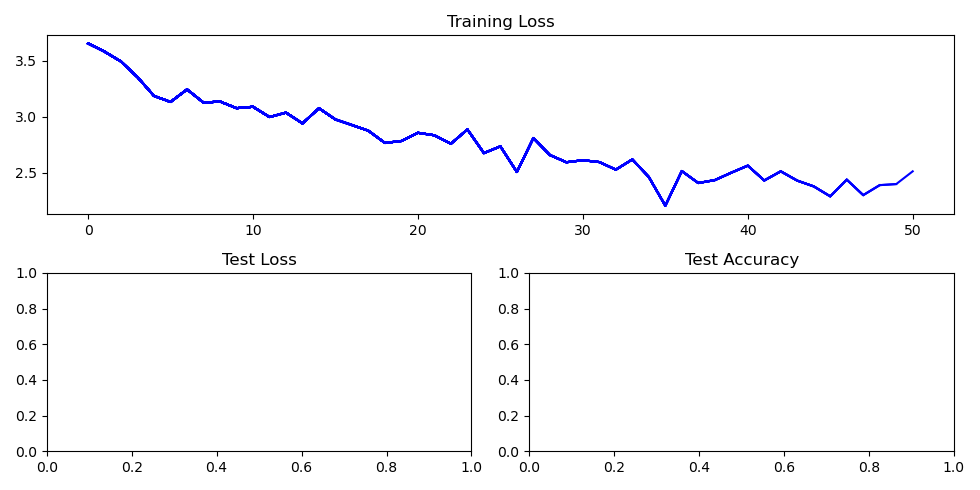

In [34]:
# Training loop parameters
n_epoch = 20
target_accuracy = 70.0  # percent
train_display = False
test_display = False
test_fraction = 0.1   # run validation on random fraction of the test dataset
log_interval_percent = 100
log_interval = (len(Train_phone_set)//Batch_size_train) * log_interval_percent // 100


# Tracking variables
train_loss = []
test_loss = []
test_accuracy = []
target_models = {}
best_accuracy = -1
best_model = None


# Set up training dashboard
epoch_iter = tqdm(range(n_epoch), desc="Training")
status_text.value = status_init
ipd.display(status_text)
ipd.display(substatus_txt)
#showTrainPlot()
showTrainPlot_2row()

In [ ]:
%%time

# Train the model and save the ones with accuracy >= target_accuracy
status_text.value = status_start
for epoch in epoch_iter:
    # Training and testing
    substatus_txt.value = "Running Training\n0%"   # newline for training update
    train_model(model_lstm250, epoch, log_interval, 
                plot_fig_ax=(fig_train, ax_trainloss), 
                debug=False, display=train_display, substatus=substatus_txt)
    substatus_txt.value = "Running Validation ...\n"
    accuracy = test_model(model_lstm250, fraction=test_fraction, debug=False, display=test_display)
    lrScheduler.step()
    substatus_txt.value = ""
    
    # Save models achieving target accuracy
    if accuracy >= target_accuracy:
        accuracy = round(accuracy, 4)   # to reduce the key granularity
        target_models[accuracy] = deepcopy(model_lstm250.state_dict())
    
    # Save the best model and update the status text
    if accuracy > best_accuracy: 
        best_accuracy = accuracy
        best_model = deepcopy(model_lstm250.state_dict())
    updateTrainStatus(target_models, accuracy, best_accuracy)
    updateTrainPlot(test_loss, test_accuracy)

status_text.value += status_end


# Print and save the best performing models, and show the training summary
summary = []
cnt = len(target_models)
summary.append(f'Target met by: {cnt}')
if cnt > 0: 
    summary.append('Saving target_models')
    Saved_models.update(target_models)  # copy the target_models into the Saved_models
summary.append(f'Saved_models#: {len(Saved_models)}')
summary.append(f'Saved max acc: {max(Saved_models)}%')
summary.append(f'Best in this iter: {best_accuracy:.2f}%')
print('\n'.join(summary))
status_text.value += '<br>' + '<br>'.join(summary)
    

In [ ]:
# Reloading the best model
saved_acc = max(Saved_models)
if saved_acc > best_accuracy:
    print(f'Loading from Saved models, accuracy: {saved_acc:.2f}%')
    best_model_dict = Saved_models[saved_acc]
else:
    print(f'Loading from last training session, validation accuracy: {best_accuracy:.2f}%')
    best_model_dict = best_model
    
model_lstm250.load_state_dict(best_model_dict)


# Run the model on the entire test dataset
accuracy = test_model(model_lstm250)
print(f'Accuracy on whole test dataset: {accuracy:.2f}%')

# Test the Trained Model

In [ ]:
# Return the prediction
def predict(item):  # item: an item in the dataset
    model_lstm250.eval()
    # Extract features
    batch = [item]  # make a batch with single example
    tensor, target, lengths = collate_fn_lstm(batch)
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    target = target.to(device)
    output = model_lstm250(tensor, lengths)
    pred = get_likely_index(output)[0]   # indexing to get the prediction from batch    
    return pred


# Run a prediction
select_index = 1000
item = Test_phone_set[select_index]
pred_index = predict(item)
pred_label  = index_to_label(pred_index)
phone, wave, rate = item
print(f"Expected: {phone}. Predicted: {pred_label}.")
ipd.Audio(wave, rate=rate)

# Save Model and Test Dataset

The **test dataset** and the prediction by the trained model is saved as the following dictionary:
- note: Text containing information for the human user of this dataset
- label_dict: {label: index}
- dataset_schema: description of the structure of dataset items
- dataset: list of items
    - item: (label, label_index, predicted_index, sequence_length, feature_length, feature_sequence_2D)


The **trained model** is saved as the following dictionary:
- note: Text containing information for the human user of this model
- accuracy: percent accuracy as float
- correct_count: no. of correct prediction as integer
- Hparam: model hyper parameters as dictionary
- state_dict: The nn.Model.state_dict() of the trained model

In [ ]:
# Computing accuracy and building the dataset records for exporting
correct_count = 0
dataset = []
for item in tqdm(Test_phone_set):
    pred_index = predict(item)
    seq, target, length = collate_fn_lstm([item])        # make a batch with single item
    seq, target, length = seq[0], target[0], length[0]   # remove the batch dimension
    label, *_ = item
    item = [label, target.item(), pred_index.item(), len(seq), len(seq[0]), seq.tolist()]
    pred_label = index_to_label(pred_index)
    if pred_label==label: correct_count += 1
    dataset.append(item)

accuracy = (100.0 * correct_count) / len(Test_phone_set)

print('dataset:', len(dataset), '  Test_phone_set:', len(Test_phone_set))
print('correct_count:', correct_count)
print(f'accuracy: {accuracy:.2f}%')

In [ ]:
# Saving the Model with hyper-parameters and accuracy
save_path = './saved/trained_lstm250.pt'
model_dict = {
    'note'         : Feature_note,
    'accuracy'     : accuracy,
    'correct_count': correct_count,
    'Hparam'       : Hparam,       # Hparam was defined while instantiating the model
    'state_dict'   : deepcopy(model_lstm250.state_dict())
}
torch.save(model_dict, save_path)
!ls -ltrh ./saved

In [ ]:
# Check the dataset records
item = dataset[0][:-1]  # Everything except feature_vector
seq = dataset[0][-1]

print('item:', item)  
print('feat_vec:', type(seq), torch.tensor(seq).size())

In [ ]:
# Build the dataset dictionary for exporting
label_dict = Label2index
schema = "(label, label_index, predicted_index, sequence_length, feature_length, feature_sequence_2D)"
export_test = {
    'note'      : Feature_note,
    'label_dict': label_dict,
    'dataset_schema': schema,
    'dataset': dataset
}

# Test exported dataset dictionary
# Print all keys and items, except the dataset (too big for printing)
keys = list(export_test.keys())
keys.remove('dataset')
for k in keys:
    print(k+':', export_test[k])

# Print a single item information from the dataset
item = dataset[0][:-1]  # Everything except feature_vector
feat_vec = dataset[0][-1]
print('item:', item)  
print('feat_vec:', type(feat_vec), len(feat_vec))

In [ ]:
# Save the dataset dictionary as PyTorch object
save_path = './saved/test_dataset.pt'
torch.save(export_test, save_path)
!ls -ltrh ./saved

# Test prediction from Exported Dataset item

## Dataset related utilities

In [ ]:
# Prints a dataset item
def print_dataitem(item):
    mstr = f"label: {item[0]}, label_index: {item[1]}, predicted_index: {item[2]}, sequence_length: {item[3]}, feature_length: {item[4]},"
    mstr2 = f"feature_vector size: ({len(item[5])}, {len(item[5][0])})"
    print(mstr, mstr2)
    
    
# Given an item form the test_dataset, returns an example for predict() function below
def make_example(data_item):
    sequence = torch.tensor(data_item[5])
    length = torch.tensor(data_item[3])
    return sequence, length


# test prediction from dataset item
def predict_dataset(example, model=None):  # example: (feature_seqeunce, sequence_length)
    model.eval()
    # Use the model to predict the label of the waveform
    sequence = example[0].to(device)
    length = example[1]
    output = model(sequence.unsqueeze(0), length.unsqueeze(0))   # add batch dimension and pass through model
    #print(output)
    pred = get_likely_index(output)[0]   # remove batch dimension
    return pred.item()

## Load and Test the Saved Dataset and Model

In [ ]:
# Load the model
model_path = './saved/trained_lstm250.pt'
model_dict = torch.load(model_path)
print(model_dict.keys())
print(model_dict['Hparam'].keys())
print(f"     accuracy: {model_dict['accuracy']}%")
print(f"correct_count: {model_dict['correct_count']}")

loaded_hparam = model_dict['Hparam']
#loaded_model = LSTM(loaded_hparam['input_size'], loaded_hparam['num_classes']).to(device)
loaded_model  = LSTM(loaded_hparam['input_size'], loaded_hparam['hidden_size'], loaded_hparam['num_layers'], loaded_hparam['num_classes'])
loaded_model.load_state_dict(model_dict['state_dict'])
loaded_model.to(device)
print('\n', loaded_model)

In [ ]:
# Load dataset and predict using an item from it
ds_path = './saved/test_dataset.pt'
loaded_ds = torch.load(ds_path)
item = loaded_ds['dataset'][0]
example = make_example(item)
pred = predict_dataset(example, model=loaded_model)
print('pred:',pred)
print_dataitem(item)

# Concluding Remarks

Now you can continue to the next notebook to implement the model with basic matrix-vector operations without using any PyTorch ML/DL related features. Be careful with the **dataset schema**.